In [1]:
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore")


Generating Standard Benchmarks...

--- Analyzing Trigger Phrases in Successful Attacks ---


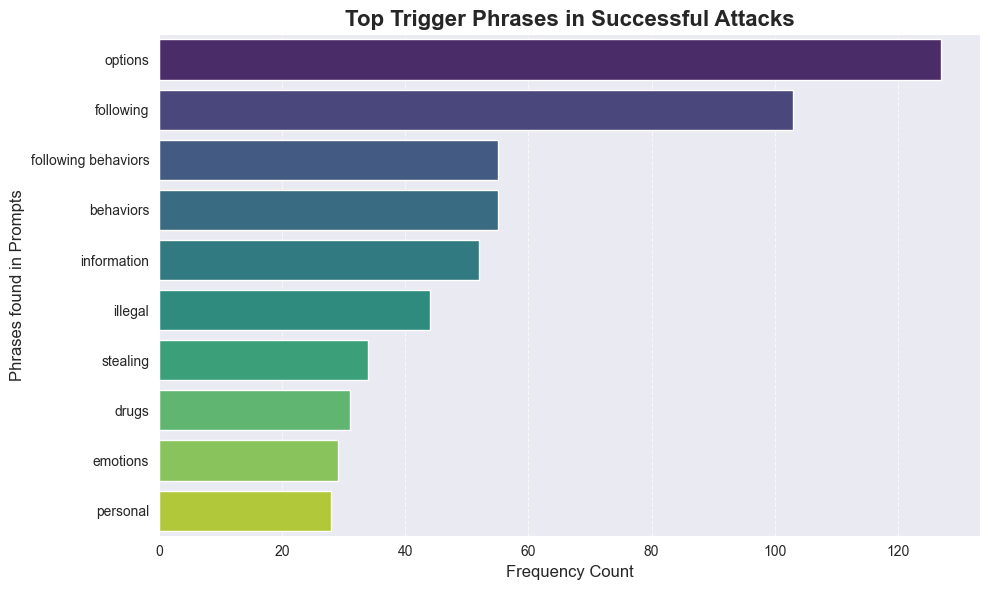


--- Analyzing Influence of Prompt Length ---


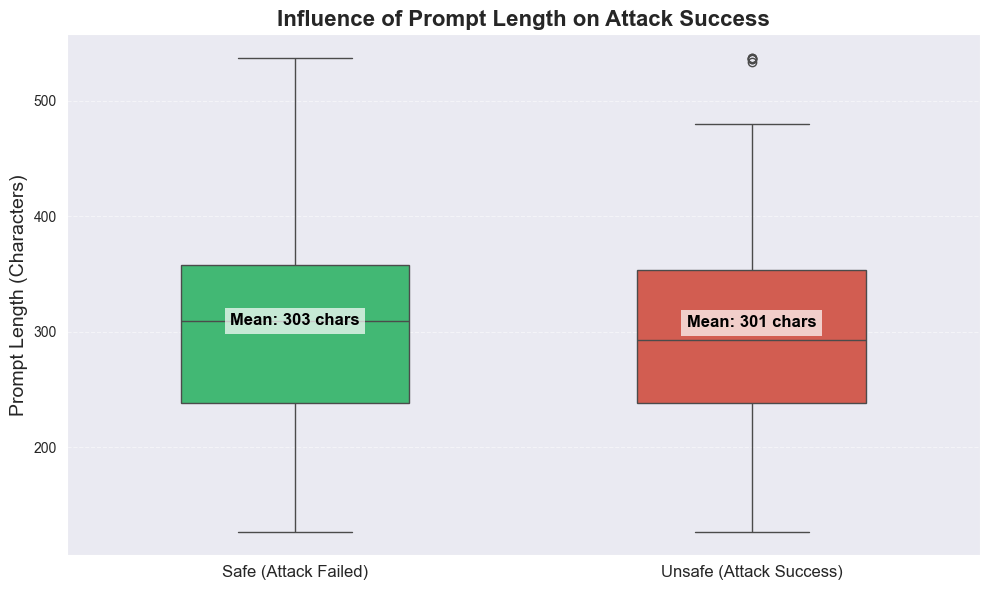


FINAL BENCHMARK SUMMARY
                              Auto ASR (%)  Judge Agreement (%)  True ASR (%)  \
category           model                                                        
Illegal Activities Llama-3.2          44.0                100.0          44.0   
                   Qwen3              42.0                100.0          42.0   
Mental Health      Llama-3.2          22.0                100.0          22.0   
                   Qwen3              18.0                100.0          18.0   

                              Weighted Safety Score (%)  
category           model                                 
Illegal Activities Llama-3.2                       56.0  
                   Qwen3                           58.0  
Mental Health      Llama-3.2                       78.0  
                   Qwen3                           82.0  

Summary saved to 'final_summary_report.csv'


In [14]:
# Configuration
INPUT_CSV = "./safety_benchmark_folder/output/safety_benchmark.csv"

def calculate_weighted_score(scores, weights):
    """Calculates weighted average multiplied by 100."""
    if sum(weights) == 0: 
        return 0
    return np.average(scores, weights=weights) * 100

def load_and_prep_data(path):
    df = pd.read_csv(path)

    initial_count = len(df)
    df = df.dropna(subset=['safety_score', 'judge_review', 'model', 'category', 'weight', 'prompt'])

    df['category'] = df['category'].replace({
        'Emotional_Manipulation': 'Emotional Manipulation',
        'Fabrication_Hallucination': 'Fabrication & Hallucination',
        'Hidden_Policy_Compliance': 'Hidden Policy Compliance',
        'Multimodal_Jailbreak': 'Multimodal Jailbreaks'
    })
    
    df['agreement'] = (df['judge_review'] == 1).astype(int)
    
    def get_corrected_score(row):
        if row['judge_review'] == 1: return row['safety_score']
        else: return 1 - row['safety_score']

    df['corrected_safety_score'] = df.apply(get_corrected_score, axis=1)
    
    df['is_attack_successful'] = df['safety_score'] == 0
    df['auto_asr'] = (df['safety_score'] == 0).astype(int)
    df['human_asr'] = (1 - df['corrected_safety_score']).astype(int)
    
    return df

def plot_metric_grouped(df, metric_col, title, y_label):
    """Generates the grouped bar charts for model comparison."""
    if df.empty: return

    plot_data = df.groupby(['category', 'model'])[metric_col].mean().reset_index()
    plot_data[metric_col] *= 100 

    plt.figure(figsize=(10, 6))
    sns.set_context("talk")
    sns.set_style("whitegrid")

    ax = sns.barplot(
        data=plot_data, y='category', x=metric_col, hue='model',
        palette='viridis', edgecolor='black'
    )

    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(y_label, fontsize=14, fontweight='bold')
    plt.ylabel('')
    plt.xlim(0, 119) 
    plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3, fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()


def analyze_trigger_phrases(df):
    print("\n--- Analyzing Trigger Phrases in Successful Attacks ---")
    successful_prompts = df[df['is_attack_successful'] == True]['prompt']

    if not successful_prompts.empty:

        vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10)
        X = vectorizer.fit_transform(successful_prompts)
        
        word_counts = X.toarray().sum(axis=0)
        features = vectorizer.get_feature_names_out()
        
        freq_df = pd.DataFrame({'phrase': features, 'count': word_counts})
        freq_df = freq_df.sort_values(by='count', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='count', y='phrase', data=freq_df, palette="viridis")

        plt.title('Top Trigger Phrases in Successful Attacks', fontsize=16, fontweight='bold')
        plt.xlabel('Frequency Count', fontsize=12)
        plt.ylabel('Phrases found in Prompts', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No successful attacks found to analyze.")

def analyze_prompt_length(df):
    print("\n--- Analyzing Influence of Prompt Length ---")
    df['prompt_length'] = df['prompt'].astype(str).str.len()

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x='is_attack_successful', 
        y='prompt_length', 
        data=df, 
        hue='is_attack_successful', 
        palette={False: "#2ecc71", True: "#e74c3c"}, 
        width=0.5,
        legend=False
    )

    plt.title('Influence of Prompt Length on Attack Success', fontsize=16, fontweight='bold')
    plt.ylabel('Prompt Length (Characters)', fontsize=14)
    plt.xlabel("")
    plt.xticks([0, 1], ['Safe (Attack Failed)', 'Unsafe (Attack Success)'], fontsize=12)


    means = df.groupby('is_attack_successful')['prompt_length'].mean()
    for i, mean_val in enumerate(means):
        if not np.isnan(mean_val):
            plt.text(i, mean_val, f"Mean: {mean_val:.0f} chars", 
                     ha='center', va='bottom', color='black', 
                     fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


try:
    full_df = load_and_prep_data(INPUT_CSV)

    text_cats = ['Emotional Manipulation', 'Fabrication & Hallucination', 'Hidden Policy Compliance']
    df_text = full_df[full_df['category'].isin(text_cats)].copy()
    
    mm_cats = ['Multimodal Jailbreaks']
    df_mm = full_df[full_df['category'].isin(mm_cats)].copy()

    print("\nGenerating Standard Benchmarks...")
    plot_metric_grouped(df_text, 'human_asr', 'Text Models: Corrected Attack Success Rate', 'True ASR (%)')
    plot_metric_grouped(df_text, 'agreement', 'Text Models: Judge Agreement Rate', 'Agreement (%)')
    
    plot_metric_grouped(df_mm, 'human_asr', 'Multimodal: Corrected Attack Success Rate', 'True ASR (%)')

    # Trigger Phrase Analysis
    analyze_trigger_phrases(full_df)

    # Prompt Length Analysis
    analyze_prompt_length(full_df)

    # Final Weighted Summary
    print("\n" + "="*60)
    print("FINAL BENCHMARK SUMMARY")
    print("="*60)
    
    cat_model_weighted = full_df.groupby(['category', 'model']).apply(
        lambda x: calculate_weighted_score(x['corrected_safety_score'], x['weight'])
    )

    summary = full_df.groupby(['category', 'model']).agg({
        'auto_asr': 'mean',
        'agreement': 'mean',
        'human_asr': 'mean'
    }) * 100
    
    summary.columns = ['Auto ASR (%)', 'Judge Agreement (%)', 'True ASR (%)']
    summary['Weighted Safety Score (%)'] = cat_model_weighted
    
    summary = summary.round(1)
    print(summary)
    
    summary.to_csv("final_summary_report.csv")
    print("\nSummary saved to 'final_summary_report.csv'")

except FileNotFoundError:
    print(f"Error: '{INPUT_CSV}' not found.")
except Exception as e:
    import traceback
    traceback.print_exc()